In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
import scipy.io as sio

from tqdm import tqdm
from time import time
import gstools as gs

from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from neuralop.models import FNO

NR, NX, NY, NZ = 1272, 128, 128, 16

In [2]:
fnames = []
for root, dirs, files in os.walk('/mnt/e/MLTrainingImages'):
    for f in files:
        if f.endswith('.npy'):
            fnames.append(os.path.join(root, f))
print('# TIs:', len(fnames))

# TIs: 318


In [8]:
facies = np.zeros((len(fnames), 4, NX, NY, NZ))
for i in tqdm(range(len(fnames))):
    f = np.load(fnames[i]).reshape(256,256,128)
    f1 = resize(f[...,48:64],   (NX,NY,NZ), anti_aliasing=True, preserve_range=True)
    f2 = resize(f[...,68:84],   (NX,NY,NZ), anti_aliasing=True, preserve_range=True)
    f3 = resize(f[...,88:104],  (NX,NY,NZ), anti_aliasing=True, preserve_range=True)
    f4 = resize(f[...,108:124], (NX,NY,NZ), anti_aliasing=True, preserve_range=True)
    ff = np.stack([f1, f2, f3, f4], axis=0)
    facies[i] = ff
facies = facies.reshape(NR, NX, NY, NZ)
print(facies.shape)

100%|██████████| 318/318 [02:49<00:00,  1.87it/s]

(1272, 128, 128, 16)


In [9]:
kmin, kmax = np.log10(0.05), np.log10(3000)
perm = np.moveaxis(np.rot90(np.array(pd.read_csv('perm_1272_128x128x16.csv')).reshape(NX,NY,NZ,NR,order='F'), axes=(0,1)), -1, 0)
perm = MinMaxScaler((kmin,kmax)).fit_transform(perm.reshape(NR,-1)).reshape(perm.shape)
print('Perm: {} | min = {:.3f} = {:.3f} | max = {:.3f} = {:.3f}'.format(perm.shape, perm.min(), 10**perm.min(), perm.max(), 10**perm.max()))

Perm: (1272, 128, 128, 16) | min = -1.301 = 0.050 | max = 3.477 = 3000.000


In [10]:
facies_norm = MinMaxScaler((0.05, 5)).fit_transform(facies.round(0).reshape(NR,-1)).reshape(facies.shape)
print('Facies: {} | min = {:.3f} | max = {:.3f}'.format(facies_norm.shape, facies_norm.min(), facies_norm.max()))

Facies: (1272, 128, 128, 16) | min = 0.050 | max = 5.000


In [11]:
perm_norm = np.log10(10**perm * facies_norm)
perm_norm = MinMaxScaler((kmin,kmax)).fit_transform(perm_norm.reshape(NR,-1)).reshape(perm_norm.shape)
print('Norm: {} | min = {:.3f} = {:.3f} | max = {:.3f} = {:.3f}'.format(perm_norm.shape, perm_norm.min(), 10**perm_norm.min(), perm_norm.max(), 10**perm_norm.max()))

Norm: (1272, 128, 128, 16) | min = -1.301 = 0.050 | max = 3.477 = 3000.000


In [12]:
np.savez('data_1272_128x128x16.npz', facies=facies, facies_norm=facies_norm, perm=perm, perm_norm=perm_norm)
sio.savemat('data_1272_128x128x16.mat', {'perm':perm_norm, 'facies':facies_norm})

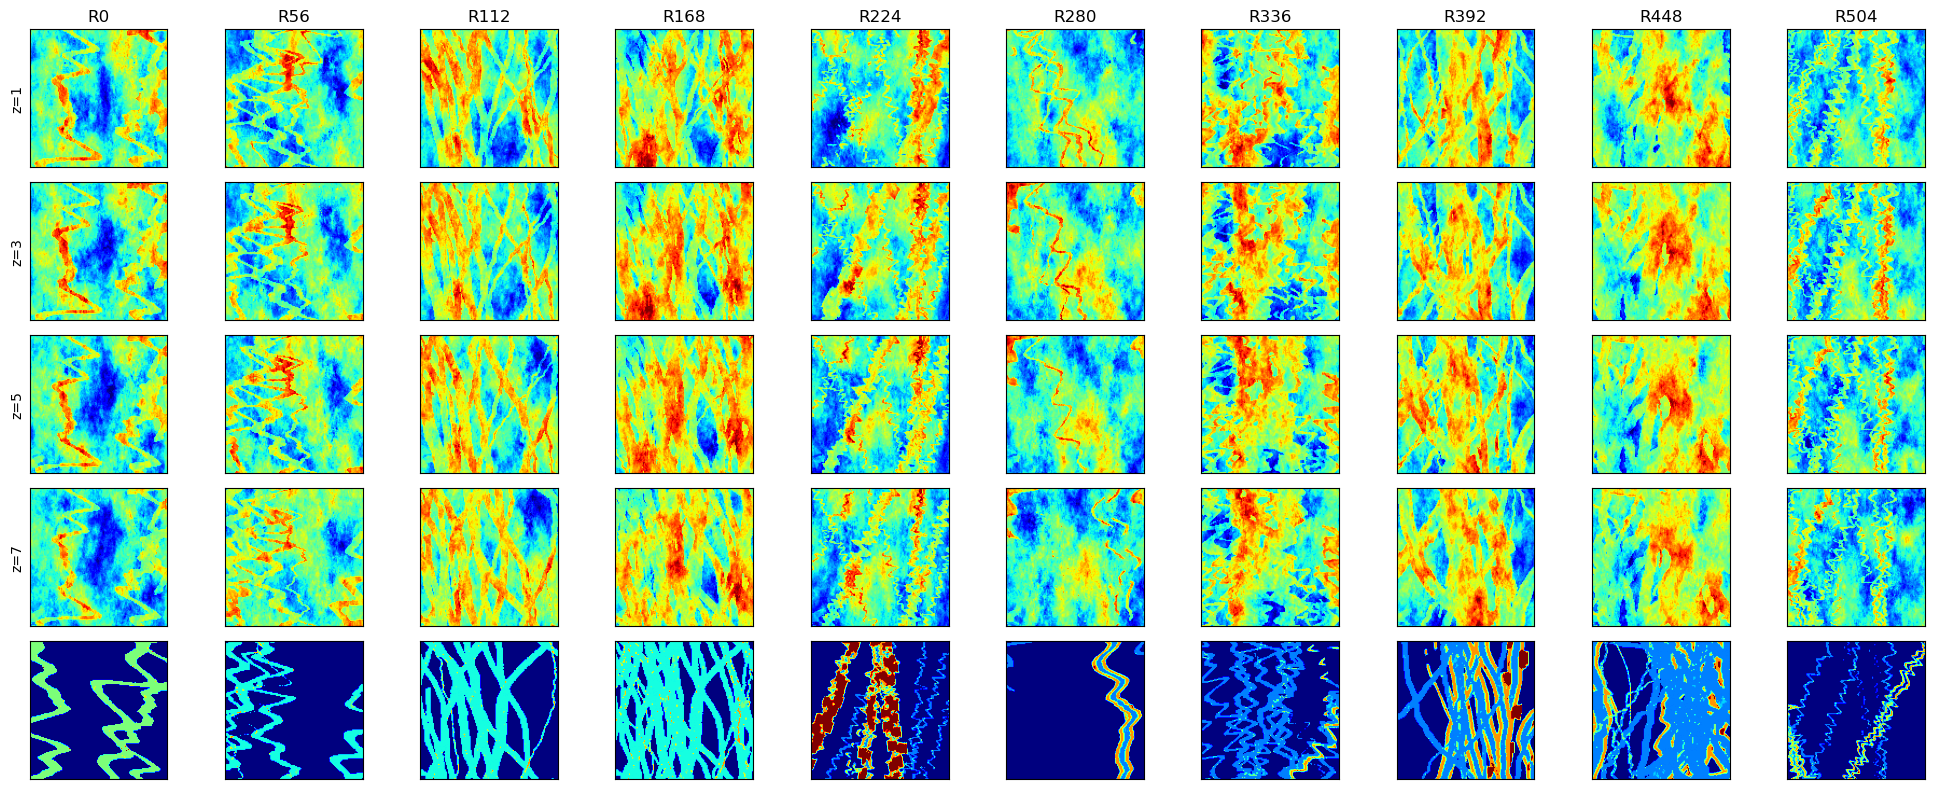

In [13]:
mult = 56

fig, axs = plt.subplots(5, 10, figsize=(20,8), sharex=True, sharey=True)
for i in range(4):
    for j in range(10):
        ax = axs[i,j]
        p, q = i*2+1, j*mult
        ax.imshow(perm_norm[q,:,:,p], cmap='jet')
        ax.set(xticks=[], yticks=[])
        ax.set_title('R{}'.format(q)) if i == 0 else None
        ax.set_ylabel('z={}'.format(p)) if j == 0 else None

for j in range(10):
    ax = axs[-1,j]
    ax.imshow(facies_norm[j*mult,:,:,-1], cmap='jet')

plt.tight_layout()
plt.show()

***
# END